<img src="https://d3i71xaburhd42.cloudfront.net/261c3e30bae8b8bdc83541ffa9331b52fcf015e6/3-Figure2-1.png" width=50% >

# <center> Assignment 1: Photometric Stereo & Colour </center>
<center> Computer Vision 1 University of Amsterdam </center>
    <center> Due 23:59 PM, September 17, 2022 (Amsterdam time) </center>
    
***

## General guidelines
Your code and discussion must be submitted through this jupyter notebook, renamed to **13486578_12167320_14334739.ipynb** before the deadline by submitting it to the Canvas Lab 1 Assignment. For full credit, make sure your answer follows these guidelines:
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make your notebook self-contained and complete.
- Analyze your results and discuss them, e.g. why algorithm A works better than algorithm B in a certain problem.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.
Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations.

## 0 Environment Set Up

You are allowed to use **only** the following library versions:
- python=3.10.4
- matplotlib==3.5.3
- matplotlib-inline==0.1.6
- numpy==1.23.2
- opencv-python==4.6.0.66

Using functions that are not working in these versions could lead to grade deduction.

## 1 Photometric Stereo (50pts)

In this part of the assignment, you are going to implement the photometric stereo algorithm as described in Section 5.4 (Forsyth and Ponce, *Computer Vision: A Modern Approach*). The chapter snippet can be found in the course materials.

Following this instruction, you will have to edit and fill in your code in the functions **estimate_alb_nrm**, **check_integrability**, and **construct_surface**. The main function **photometric_stereo** is provided for reference and should not be taken as is. Throughout the assignment, you will be asked to perform different trials and experiments which will require you to adjust the main code accordingly, this also shows how well you can cope with the materials.

Include images of the results into this notebook. For 3D models, make sure to choose a viewpoint that makes the structure as clear as possible and/or feel free to take them from multiple viewpoints.

### 1.1 Estimating Albedo and Surface Normal (15pts)
Let us start with the grayscale sphere model, which is located in the SphereGray5 folder. The folder contains 5 images of a sphere with grayscale checker texture under similar lighting conditions with the one in the book. Your task is to estimate the surface reflectance (albedo) and surface normal of this model. The light source directions are encoded in the image file names.

1. Complete the code for function **estimate_alb_nrm()** to estimate albedo and surface normal map for the SphereGray5 folder. What do you expect to see in albedo image and how is it different with your result?
2. In principle, what is the minimum number of images you need to estimate albedo and surface normal? Run the algorithm with more images by using SphereGray25 and observe the differences in the results. You could try all images at once or a few at the time, in an incremental fashion. Choose a strategy and justify it by discussing your results.
3. What is the impact of shadows in photometric stereo? Explain the trick that is used in the text to deal with shadows. Remove that trick and check your results. Is the trick necessary in the case of 5 images, how about 25 images?

**Hint**: To get the least-squares solution of a linear system, you can use **numpy.linalg.lstsq** function.

In [1]:
# First some utils we need
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def load_syn_images(image_dir='./SphereGray5/', channel=0):
    files = os.listdir(image_dir)
    #files = [os.path.join(image_dir, f) for f in files]
    nfiles = len(files)

    image_stack = None
    V = 0
    Z = 0.5

    for i in range(nfiles):
        # read input image
        im = cv2.imread(os.path.join(image_dir, files[i]))
        im = im[:,:,channel]

        # stack at third dimension
        if image_stack is None:
            h, w = im.shape
            print('Image size (H*W): %d*%d' %(h,w) )
            image_stack = np.zeros([h, w, nfiles], dtype=int)
            V = np.zeros([nfiles, 3], dtype=np.float64)

        image_stack[:,:,i] = im

        # read light direction from image name
        X = np.double(files[i][(files[i].find('_')+1):files[i].rfind('_')])
        Y = np.double(files[i][files[i].rfind('_')+1:files[i].rfind('.png')])
        V[i, :] = [-X, Y, Z]

    # normalization
    image_stack = np.double(image_stack)
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val) if max_val != min_val else image_stack  #  Fixed for when max_val == min_val
    normV = np.tile(np.sqrt(np.sum(V ** 2, axis=1, keepdims=True)), (1, V.shape[1]))
    scriptV = V / normV

    return image_stack, scriptV


def load_face_images(image_dir='./yaleB02/'):
    num_images = 64
    filename = os.path.join(image_dir, 'yaleB02_P00_Ambient.pgm')
    ambient_image = cv2.imread(filename, -1)
    h, w = ambient_image.shape

    # get list of all other image files
    import glob, random
    d = glob.glob(os.path.join(image_dir, 'yaleB02_P00A*.pgm'))
    d = random.sample(d, num_images)
    filenames = [os.path.basename(x) for x in d]

    ang = np.zeros([2, num_images])
    image_stack = np.zeros([h, w, num_images])

    for j in range(num_images):
        ang[0,j], ang[1,j] = np.double(filenames[j][12:16]), np.double(filenames[j][17:20])
        image_stack[...,j] = cv2.imread(os.path.join(image_dir, filenames[j]), -1) - ambient_image


    x = np.cos(np.pi*ang[1,:]/180) * np.cos(np.pi*ang[0,:]/180)
    y = np.cos(np.pi*ang[1,:]/180) * np.sin(np.pi*ang[0,:]/180)
    z = np.sin(np.pi*ang[1,:]/180)
    scriptV = np.array([y,z,x]).transpose(1,0)

    image_stack = np.double(image_stack)
    image_stack[image_stack<0] = 0
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)

    return image_stack, scriptV


def load_apple_images(image_dir='./Apples_png/'):
    num_images = 100
    filename = os.path.join(image_dir, 'I_0000.png')
    try_image = cv2.imread(filename, -1)
    h, w = try_image[:,:,0].shape

    # get list of all other image files
    import glob
    d = glob.glob(os.path.join(image_dir, 'I_0*.png'))
    import random
    d = random.sample(d, num_images)
    filenames = [os.path.basename(x) for x in d]
    filenames_idx = []
    for i in filenames:
        filenames_idx.append(int(i.split('_')[1].split('.')[0]))

    ang = np.zeros([2, num_images])
    image_stack = np.zeros([h, w, num_images])

    for j in range(num_images):
        image_stack[...,j] = cv2.imread(os.path.join(image_dir, filenames[j]), -1)[:,:,0]

    with open('./images/photometrics_images/Apple/light_directions_refined.txt') as file:
        lines = [line.split() for line in file]
        x, y, z = [], [], []
        for idx in filenames_idx:
            x.append(float(lines[idx][0]))
            y.append(float(lines[idx][1]))
            z.append(float(lines[idx][2]))

    scriptV = np.array([y,z,x]).transpose(1,0)

    image_stack = np.double(image_stack)
    image_stack[image_stack<0] = 0
    min_val = np.min(image_stack)
    max_val = np.max(image_stack)
    image_stack = (image_stack - min_val) / (max_val - min_val)

    return image_stack, scriptV


def show_results(albedo, normals, height_map, SE):
    # Stride in the plot, you may want to adjust it to different images
    stride = 1

    # showing albedo map
    fig = plt.figure()
    fig.suptitle('Albedo map')
    albedo_max = albedo.max()
    albedo_max = 1
    albedo = albedo / albedo_max
    plt.imshow(albedo, cmap="gray")
    plt.show()

    # showing normals as three separate channels
    figure = plt.figure(figsize=(8,2))
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    figure.suptitle('Surface normals as three separate channels')
    plt.show()

    # meshgrid
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
    np.arange(0,np.shape(normals)[1], stride),
    np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]

    '''
    =============
    You could further inspect the shape of the objects and normal directions by using plt.quiver() function.
    =============
    '''

    # plotting the SE
    H = SE[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.title('Squared Error')
    plt.show()

    # plotting model geometry
    H = height_map[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.title('Height Map')
    plt.show()


In [ ]:
def estimate_alb_nrm( image_stack, scriptV, shadow_trick=True):

    # COMPUTE_SURFACE_GRADIENT compute the gradient of the surface
    # INPUT:
    # image_stack : the images of the desired surface stacked up on the 3rd dimension
    # scriptV : matrix V (in the algorithm) of source and camera information
    # shadow_trick: (true/false) whether or not to use shadow trick in solving linear equations
    # OUTPUT:
    # albedo : the surface albedo
    # normal : the surface normal

    h, w, _ = image_stack.shape

    # create arrays for
    # albedo (1 channel)
    # normal (3 channels)
    albedo = np.zeros([h, w])
    normal = np.zeros([h, w, 3])

    """
    for each point in the image array
        stack image values into a vector i
        construct the diagonal matrix scriptI
        solve scriptI * scriptV * g = scriptI * i to obtain g for this point
        albedo at this point is |g|
        normal at this point is g / |g|
    """
    for x in range(h):
        for y in range(w):
            i = image_stack[x, y, :]

            if shadow_trick == True:
                scriptI = np.diag(i)
                g = np.linalg.lstsq(scriptI@scriptV, scriptI@i, rcond=None)[0]

            else:
                g = np.linalg.lstsq(scriptV, i, rcond=None)[0]


            norm_g = np.linalg.norm(g)

            albedo[x, y] = norm_g
            normal[x, y,:] = g/norm_g if norm_g != 0 else 0

    return albedo, normal


In [ ]:
#  Question 1.1.1
image_stack, scriptV = load_syn_images(image_dir='./images/photometrics_images/SphereGray5/')
albedo, normal = estimate_alb_nrm(image_stack, scriptV, shadow_trick=True)
h, w = image_stack.shape[0], image_stack.shape[1]

#  We don't need SE and height map yet so just use a zero placeholder
SE = np.zeros(normal.shape[:2])
height_map = np.zeros([h, w])

show_results(albedo, normal, height_map, SE)

1.1.1
...

In [ ]:
#  Question 1.1.2
image_stack, scriptV = load_syn_images(image_dir='./images/photometrics_images/SphereGray25/')
albedo, normal = estimate_alb_nrm(image_stack, scriptV, shadow_trick=True)
h, w = image_stack.shape[0], image_stack.shape[1]

#  We don't need SE and height map yet so just use a zero placeholder
SE = np.zeros(normal.shape[:2])
height_map = np.zeros([h, w])

show_results(albedo, normal, height_map, SE)

1.1.2
...

In [ ]:
#  Question 1.1.3


# SphereGray5
image_stack, scriptV = load_syn_images(image_dir='./images/photometrics_images/SphereGray5/')
albedo, normal = estimate_alb_nrm(image_stack, scriptV, shadow_trick=False)
h, w = image_stack.shape[0], image_stack.shape[1]

#  We don't need SE and height map yet so just use a zero placeholder
SE = np.zeros(normal.shape[:2])
height_map = np.zeros([h, w])

show_results(albedo, normal, height_map, SE)


# SphereGray25
image_stack, scriptV = load_syn_images(image_dir='./images/photometrics_images/SphereGray25/')
albedo, normal = estimate_alb_nrm(image_stack, scriptV, shadow_trick=False)
h, w = image_stack.shape[0], image_stack.shape[1]

#  We don't need SE and height map yet so just use a zero placeholder
SE = np.zeros(normal.shape[:2])
height_map = np.zeros([h, w])

show_results(albedo, normal, height_map, SE)

1.1.3
...

### 1.2 Test of Integrability (10pts)

Before we can reconstruct the surface height map, it is required to compute the partial derivatives $\frac{\delta f}{\delta x}$ and $\frac{\delta f}{\delta y}$ (or *p* and *q* in the algorithm). The partial derivatives also give us a chance to double check our computation, namely the test of *integrability*.

1. Compute the partial derivatives (p and q in the algorithm) by filling in your code into **check_integrability()**.

In [ ]:
def check_integrability(normals):
    #  CHECK_INTEGRABILITY check the surface gradient is acceptable
    #   normals: normal image
    #   p : df / dx
    #   q : df / dy
    #   SE : Squared Errors of the 2 second derivatives

    # initalization
    p = np.zeros(normals.shape[:2])
    q = np.zeros(normals.shape[:2])
    SE = np.zeros(normals.shape[:2])

    """
    Compute p and q, where
    p measures value of df / dx
    q measures value of df / dy

    """
    p = np.divide(normals[:,:, 0], normals[:,:, 2])
    q = np.divide(normals[:,:, 1], normals[:,:, 2])

    # change nan to 0
    p[p!=p] = 0
    q[q!=q] = 0

    """
    approximate second derivate by neighbor difference
    and compute the Squared Errors SE of the 2 second derivatives SE

    """
    h, w, _ = normals.shape

    dpdy = np.diff(p, axis=1)
    dpdy = np.hstack((dpdy, np.zeros((h, 1))))
    dqdx = np.diff(q, axis=0)
    dqdx = np.vstack((dqdx, np.zeros((1, w))))
    SE = (dpdy - dqdx)**2

    return p, q, SE

if __name__ == '__main__':
    normals = normal
    p, q, SE = check_integrability(normals)
    plt.imshow(SE)

2. Implement and compute the second derivatives according to the algorithm and perform the test of integrability by choosing a reasonable threshold. What could be the reasons for the errors? How does the test perform with different number of images used in the reconstruction process in Question 1?

*Write your answer here*

### 1.3 Shape by Integration (10pts)
To reconstruct the surface height map, we need to continuously integrate the partial derivatives over a path. However, as we are working with discrete structures, you will be simply summing their values.

The algorithm in the chapter presents a way to do the integration in column-major order, that is you start at the top-left corner and integrate along the first column, then go towards right along each row. Yet, it is also noticed that it would be better to use many different paths and average so as to spread around the errors in the derivative estimates.

1. Construct the surface height map using column-major order as described in the algorithm, then implement row-major path integration. Your code should now go to **construct_surface()**.

**Note**: By default, Numpy used row-major operations. So if you are unrolling an image to linearize the operation, you will end up with a row-major representation. Numpy can be configured to be column-major. Otherwise, if you are using the double for-loops without an unrolling operation, then this concern doesn’t apply.

**Hint**: You could further inspect the shape of the objects and normal directions by using **matplotlib.pyplot.quiver** function. You will have to choose appropriate sub-sampling ratios for proper illustration. You code goes to the **show_results()** in the first code cell.

In [ ]:
def construct_surface(p, q, path_type='average'):

    '''
    CONSTRUCT_SURFACE construct the surface function represented as height_map
       p : measures value of df / dx
       q : measures value of df / dy
       path_type: type of path to construct height_map, either 'column',
       'row', or 'average'
       height_map: the reconstructed surface
    '''

    h, w = p.shape
    height_map = np.zeros([h, w])

    if path_type=='column':
        for u in range(1,h):
            height_map[u,0] = height_map[u-1,0] + q[u,0]
        for u in range(0,h):
            for v in range(1,w):
                height_map[u,v] = height_map[u,v-1] + p[u,v]

    elif path_type=='row':
        for v in range(1,w):
            height_map[0,v] = height_map[0,w-1] + p[0,v]
        for v in range(0,w):
            for u in range(1,h):
                height_map[u,v] = height_map[u-1,v] + q[u,v]

    elif path_type=='average':
        height_map_col = np.zeros([h, w])
        height_map_row = np.zeros([h, w])
        for u in range(1,h):
            height_map_col[u,0] = height_map_col[u-1,0] + q[u,0]
        for u in range(0,h):
            for v in range(1,w):
                height_map_col[u,v] = height_map_col[u,v-1] + p[u,v]
        for v in range(1,w):
            height_map_row[0,v] = height_map_row[0,w-1] + p[0,v]
        for v in range(0,w):
            for u in range(1,h):
                height_map_row[u,v] = height_map_row[u-1,v] + q[u,v]
        height_map = height_map_col + height_map_row / 2

    return height_map

In [ ]:
hm = construct_surface(p, q, path_type='column')
plt.imshow(hm)
plt.colorbar()
show_results(albedo, normal,  hm, SE)

hm = construct_surface(p, q, path_type='row')
plt.imshow(hm)
plt.colorbar()
show_results(albedo, normal,  hm, SE)

hm = construct_surface(p, q, path_type='average')
plt.imshow(hm)
plt.colorbar()
show_results(albedo, normal,  hm, SE)

2. What are the differences in the results of the two paths?


*Write your answer here*

3. Now, take the average of the results. Do you see any improvement compared to when using only one path? Are the construction results different with different number of images being used?

*Write your answer here*

### 1.4 Experiments with different objects (15pts)
In this part, you will try to run the photometric stereo algorithm in various number of scenarios to see how well it can be generalized.

1. Run the algorithm and show the results for the MonkeyGray model. 

In [ ]:
def photometric_stereo_helpfun(image_stack, scriptV, shadow_trick=True, path_type='column'):  # Helper function for the following photometric_stereo functions to avoid code repetition
    # N = 5  #  Limit the number of images to N
    # image_stack = image_stack[:,:,:N]
    # scriptV = scriptV[:N]

    [h, w, n] = image_stack.shape

    print('Finish loading %d images.\n' % n)

    # compute the surface gradient from the stack of imgs and light source mat
    print('Computing surface albedo and normal map...\n')
    [albedo, normals] = estimate_alb_nrm(image_stack, scriptV, shadow_trick)

    # integrability check: is (dp / dy  -  dq / dx) ^ 2 small everywhere?
    print('Integrability checking\n')
    [p, q, SE] = check_integrability(normals)

    threshold = 0.005;
    print('Number of outliers: %d\n' % np.sum(SE > threshold))
    SE[SE <= threshold] = float('nan') # for good visualization

    # compute the surface height
    height_map = construct_surface( p, q, path_type=path_type)

    # show results
    show_results(albedo, normals, height_map, SE)

def photometric_stereo(image_dir='./SphereGray5/', channel=0, shadow_trick=True):

    # obtain many images in a fixed view under different illumination
    print('Loading images...\n')
    [image_stack, scriptV] = load_syn_images(image_dir, channel=channel)

    photometric_stereo_helpfun(image_stack, scriptV, shadow_trick)

## Face
def photometric_stereo_face(image_dir='./yaleB02/', shadow_trick=True, path_type='column'):
    [image_stack, scriptV] = load_face_images(image_dir)
    photometric_stereo_helpfun(image_stack, scriptV, shadow_trick, path_type)
    
## Apple
def photometric_stereo_apple(image_dir='./Apple_png/', shadow_trick=True, path_type='column'):
    [image_stack, scriptV] = load_apple_images(image_dir)
    photometric_stereo_helpfun(image_stack, scriptV, shadow_trick, path_type)


In [ ]:
photometric_stereo(image_dir='./images/photometrics_images/MonkeyGray/')

2. The albedo results of the monkey may comprise more albedo errors than in case of the sphere. Observe and describe the errors. What could be the reason for those errors? You may want to experiment with different number of images as you did in Question 1 to see the effects. 

It seems that most of the errors occur on the parts of the object that cannot be seen fully from the point of view that the image depicts. For instance, in the case of the monkey, only the front faces of the object can be seen fully but the side faces cannot and therefore cause the most errors when generating the surface. Compared to the monkey, the sphere's shape has less "hidden faces" and this is the reason there are fewer errors. The reason for the errors is that, since the side faces cannot be seen properly, the photometric images contain less information about them compared to the front faces. Thus, the albedo and 3d reconstruction of the surface is more erroneous.

3. How do you think that could help solving these errors?

By increasing the number of images, we can see the object in more lighting conditions. This increases the information we have about the surface of the object. Therefore, the albedo and surface produced becomes more accurate.

So far, we have assumed that albedos are 1-channel grayscale images and that input images are also 1-channel. To work with 3-channel images, a simple solution is to split the input image into separate channels and treat them individually. Yet, that would generate a small problem while constructing the surface normal map if a pixel value in a channel is zero.

1. Update the implementation to work for 3-channel RGB inputs and test it with 2 models SphereColor and MonkeyColor. 
2. Explain your changes and show your results.

In [ ]:
#  SphereColor
channels = 3  # Number of channels
for c in range(channels):
    print(f'RESULTS FOR CHANNEL {c} ----------------------------------------------------------------------------')
    photometric_stereo(image_dir='./images/photometrics_images/SphereColor/', channel=c)

In [ ]:
#  MonkeyColor
channels = 3  # Number of channels
for c in range(channels):
    print(f'RESULTS FOR CHANNEL {c} ----------------------------------------------------------------------------')
    photometric_stereo(image_dir='./images/photometrics_images/MonkeyColor/', channel=c)

Simply, for each channel we execute the photometric_stereo function with the specific channel index. To do this, we added the new argument "channel" to the photometric_stereo function. Also, to avoid code repetition among all photometric_stereo functions, we added the new helper function photometric_stereo_helpfun.

3. Observe the problem in the constructed surface normal map and height map, explain why a zero pixel could be a problem and propose a way to overcome that.

The problem in the results is that, when treating the channels individually, a pixel that has a 0 value for the specific color channel will appear as if it is part of the black background or, more intuitively, that the shape has a "hole", even though that is not the case. A way to overcome that would be to convert the RGB image to Grayscale and then from that extract the 3D surface. There are three ways to do this [See exercise 2.2 Color Space Conversion] but, for instance, we could take the average of the Red, Green and Blue values.

Now, it's the time to try the algorithm on real-world datasets. For that purpose, we are going to use the [Yale Face Database](http://cvc.cs.yale.edu/cvc/projects/yalefaces/yalefaces.html)

1. Run the algorithm for the Yale Face images (included in the lab material). 
2. Observe and discuss the results for different integration paths. 

**Hint**: For proper computation of albedo and surface normal, you may want to suspend the shadow trick described in the text, and use the original formula:
$$i = Vg(x,y)$$

In [ ]:
# yaleB02 with column integration
photometric_stereo_face(image_dir='./images/photometrics_images/yaleB02/', shadow_trick=False, path_type='column')

In [ ]:
# yaleB02 with row integration
photometric_stereo_face(image_dir='./images/photometrics_images/yaleB02/', shadow_trick=False, path_type='row')

In [ ]:
# yaleB02 with average integration
photometric_stereo_face(image_dir='./images/photometrics_images/yaleB02/', shadow_trick=False, path_type='average')

The best visual result occurs from the average path integration. With column path integration it seems that the top and bottom of the face are tilted upwards, whereas with row path integration the left and right sides of the face are tilted upwards.

3. Discuss how the images violate the assumptions of the shape-from-shading methods. Remember to include specific input images to illustrate your points. 


*Write your answer here*

4. How would the results improve when the problematic images are all removed? Try it out and show the results here.

*Write your answer here*

Finally, show your results on real-world 3-channel RGB inputs, contained in the "Apple" folder, taken from [this dataset](http://vision.ucsd.edu/~nalldrin/research/cvpr08/datasets/) from the University of California San Diego.

1. Observe and discuss the results for different integration paths.

In [ ]:
# Apple with column integration
photometric_stereo_apple(image_dir='./images/photometrics_images/Apple/', shadow_trick=False, path_type='column')

In [ ]:
# Apple with row integration
photometric_stereo_apple(image_dir='./images/photometrics_images/Apple/', shadow_trick=False, path_type='row')

In [ ]:
# Apple with average integration
photometric_stereo_apple(image_dir='./images/photometrics_images/Apple/', shadow_trick=False, path_type='average')

## 2 Colour Spaces (20pts)

In this part of the assignment, you will study the different colour spaces for image representations and experiment how to convert a given RGB image to a specific colour space.

### 2.1 RGB Colour Model (3pts)

Why do we use RGB colour model as a basis of our digital cameras and photography? How does a standard digital camera capture the full RGB colour image?

### 2.2 Colour Space Conversion (10pts)

Create a function to convert an RGB image into the following colour spaces by using the template code you are provided at the ConvertColourSpace function and other sub-functions. Visualize the new image and its channels separately in the same figure. That is, for example, in the case of HSV colour space, you need to visualize the converted HSV image, and its Hue, Saturation and Value channels separately (4 images, 1 figure). Do not change the already given code.

__Opponent Colour Space__

$\begin{pmatrix}
O_1 \\
O_2 \\
O_3
\end{pmatrix}$ = $\begin{pmatrix}
\frac{R-G}{\sqrt{2}} \\
\frac{R+G-2B}{\sqrt{6}} \\
\frac{R+G+B}{\sqrt{3}}
\end{pmatrix}$

__Normalized RGB (rgb) Colour Space__

$\begin{pmatrix}
r \\
g \\
b
\end{pmatrix}$ = $\begin{pmatrix}
\frac{R}{R+G+B} \\
\frac{G}{R+G+B} \\
\frac{B}{R+G+B}
\end{pmatrix}$

__HSV Colour Space__

Convert the RGB image into HSV Colour Space. Use OpenCV’s built-in function *cv2.cvtColor(img, cv2.RGB2HSV)*.

__YCbCr Colour Space__

Convert the RGB image into YCbCr Colour Space. Use OpenCV’s built-in function *cv2.cvtColor(img, cv2.RGB2YCrCb)*. Note, you need to arrange the channels in $Y, C_b$ and $C_r$ order.

__Grayscale__

Convert the RGB image into grayscale by using 3 different methods mentioned in
https://www.johndcook.com/blog/2009/08/24/algorithms-convert-color-grayscale/
In the end, check and report which method OpenCV uses for grayscale conversion, include it as well, and visualize all 4 in the same figure.




In [2]:
def rgb2grays(input_image):
    # converts an RGB into grayscale by using 4 different methods
    RGB = getColourChannels(input_image)
    new_image = []
    
    # ligtness method
    new_image.append((np.maximum.reduce(RGB) + np.minimum.reduce(RGB)) / 2)
    # average method
    new_image.append(np.mean(RGB, axis=0))
    # luminosity method
    new_image.append((RGB[0]*0.21 + RGB[1]*0.72 + RGB[2]*0.7) / 3)
    # built-in opencv function
    new_image.append(cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY))
#     print(new_image)
    return new_image


def rgb2opponent(input_image):
    # converts an RGB image into opponent colour space
    R, G, B = getColourChannels(input_image)
    new_image = []
    zeros = np.zeros(input_image[:, :, 0].shape)
    
    # perform opponent converstion but make it so that the values return in the RGB range
    O1 = ((R - G) / np.sqrt(2) + (255 / np.sqrt(2))) * 255 * np.sqrt(2) / 510
    O2 = (((R + G - 2 * B) / np.sqrt(6)) + (510 / np.sqrt(6))) * 255 * np.sqrt(6) / 1020
    O3 = (((R + G + B) / np.sqrt(3)) + (765 / np.sqrt(3))) * 255 * np.sqrt(3) / 1530

    new_image.append(np.dstack((O1, O2, O3)))
    new_image.append(np.dstack((O1, zeros, zeros)))
    new_image.append(np.dstack((zeros, O2, zeros)))
    new_image.append(np.dstack((zeros, zeros, O3)))
    return new_image

def rgb2normedrgb(input_image):
    # converts an RGB image into normalized rgb colour space
    R, G, B = getColourChannels(input_image)
    new_image = []
    zeros = np.zeros(input_image[:, :, 0].shape)

    r = R / (R + G + B) * 255
    g = G / (R + G + B) * 255
    b = B / (R + G + B) * 255
    
    new_image.append(np.dstack((r, g, b)))
    new_image.append(np.dstack((r, zeros, zeros)))
    new_image.append(np.dstack((zeros, g, zeros)))
    new_image.append(np.dstack((zeros, zeros, b)))
    return new_image

def getColourChannels(input_image):

    R = input_image[:, :, 0]
    G = input_image[:, :, 1]
    B = input_image[:, :, 2]

    return [R, G, B]

In [5]:
def visualize(input_image):
    # Fill in this function. Remember to remove the pass command

    # check if list of images
    if len(input_image) > 4:
        plt.figure()
        plt.imshow(input_image.astype(np.uint16))

    # check if grey image
    elif len(input_image[0][0].shape) == 1:
        fig = plt.figure(figsize=(10, 5))
        for i in range(len(input_image)):
            plt.subplot(1, 4, i+1)
            plt.imshow((input_image[i].astype(np.uint16)), cmap='gray')
        fig.tight_layout()
    
    else:
        fig = plt.figure(figsize=(10, 5))
        for i in range(len(input_image)):
            plt.subplot(1, 4, i+1)
            plt.imshow((input_image[i]).astype(np.uint16))
        fig.tight_layout()




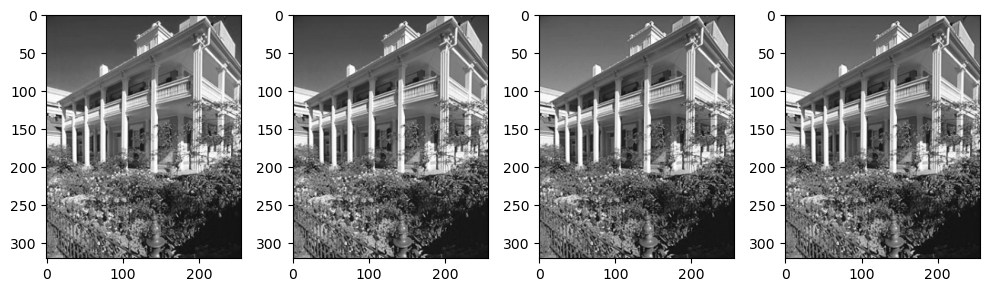

In [6]:
def ConvertColourSpace(input_image, colourspace):
    '''
    Converts an RGB image into a specified color space, visualizes the
    color channels and returns the image in its new color space.

    Colorspace options:
      opponent
      rgb -> for normalized RGB
      hsv
      ycbcr
      gray

    P.S: Do not forget the visualization part!
    '''

    # Convert the image into double precision for conversions
    input_image = input_image.astype(np.float32)

    if colourspace.lower() == 'opponent':
        # fill in the rgb2opponent function
        new_image = rgb2opponent(input_image )

    elif colourspace.lower() == 'rgb':
        # fill in the rgb2opponent function
        new_image = rgb2normedrgb(input_image)

    elif colourspace.lower() == 'hsv':
        # use built-in function from opencv
        new_image = []
        hsv = cv2.cvtColor(input_image, cv2.COLOR_RGB2HSV)
        zeros = np.zeros(input_image[:, :, 0].shape)
        
        H = hsv[:, :, 0] / 360 * 255
        S = hsv[:, :, 1] * 255
        V = hsv[:, :, 2] 
    
        new_image.append(np.dstack((H, S, V)))
        new_image.append(np.dstack((H, zeros, zeros)))
        new_image.append(np.dstack((zeros, S, zeros)))
        new_image.append(np.dstack((zeros, zeros, V)))

    elif colourspace.lower() == 'ycbcr':
        # use built-in function from opencv
        new_image = []
        ycbcr = cv2.cvtColor(input_image, cv2.COLOR_RGB2YCrCb)
        zeros = np.zeros(input_image[:, :, 0].shape)

        
        Y = ycbcr[:, :, 0]
        Cb = ycbcr[:, :, 2] + 128
        Cr = ycbcr[:, :, 1] + 128
        
        new_image.append(np.dstack((Y, Cb, Cr)))
        new_image.append(np.dstack((Y, zeros, zeros)))
        new_image.append(np.dstack((zeros, Cb, zeros)))
        new_image.append(np.dstack((zeros, zeros, Cr)))

    elif colourspace.lower() == 'gray':
        # fill in the rgb2opponent function
        new_image = rgb2grays(input_image)

    else:
        print('Error: Unknown colorspace type [%s]...' % colourspace)
        new_image = input_image

#     print(new_image[0])
    visualize(new_image)
    return new_image


if __name__ == '__main__':
    # Replace the image name with a valid image
    img_path = 'images/awb/awb.jpg'
    # Read with opencv
    I = cv2.imread(img_path)
    # Convert from BGR to RGB
    # This is a shorthand.
    I = I[:, :, ::-1]

    out_img = ConvertColourSpace(I, 'gray')



**2.1**
We use the RGB color model because it comprises the three primary additive colors, red, green and blue. With these three colors we can produce any color we want, including white, which occurs when all colors are mixed [Szeliski Book Fig. 2.8]. We use additive colors because the contrast they create with black screens works very well to produce digital images [1]. RGB is also convenient because it mimics the trichromatic nature of the human eye, which has different types of receptors called cones to sense red, green and blue [Lecture 2]. To capture a colored image, a standard digital camera is equipped with sensors that translate the wavelength of the photons to an RGB value. To achieve this, the sensors contain a Bayer Filter, which has the appearance of a checkboard with red, green and blue squares [Lecture 2].

[1] https://medium.com/nerd-for-tech/the-color-theory-why-do-computers-use-rgb-instead-of-ryb-205b75d6e783

**2.2**
cv2.COLOR_BGR2GRAY uses the luminosity method (run the above cell with 'out_img = ConvertColourSpace(I, 'gray')', the differences between the images can be seen clearly in the top left of each image). 

### 2.3 Colour Space Properties (5pts)

Explain each of those 5 colour spaces and their properties. What are the benefits of using a different colour space other than RGB? Provide reasons for each of the above cases. You can include your observations from the visualizations.

opponent: 
normalized RGB: 
hsv:
ycbcr: 
gray: 

### 2.4 More on Colour Spaces (2pts)

Find one more colour space from the literature and simply explain its properties and give a use case.

CIELAB 

## 3 Intrinsic Image Decomposition (15pts)
Intrinsic image decomposition is the process of separating an image into its formation components, such as reflectance (albedo) and shading (illumination). <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) Then, under the assumption of body (diffuse) reflection, linear sensor response and narrow band filters, the decomposition of the observed image $I(\vec{x})$ at position $\vec{x}$ can be approximated as the element-wise product of its albedo $R(\vec{x})$ and shading $S(\vec{x})$ intrinsics:

$$I(\vec{x})=R(\vec{x}) \times S(\vec{x})$$

In this part of the assignment, you will experiment with intrinsic image components to perform one of the computational photography applications; material recolouring. For the experiments, we will use images from a synthetic intrinsic image dataset. <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2)

<a name="cite_note-1"></a><small>1. [^](#cite_ref-1) H. G. Barrow and J. M. Tenenbaum. Recovering intrinsic scene characteristics from images. Computer Vision Systems, pages 3-26, 1978.</small>

<a name="cite_note-2"></a><small>2. [^](#cite_ref-1) http://www.cic.uab.cat/Datasets/synthetic_intrinsic_image_dataset/



1. What other components can an image be decomposed other than albedo and shading Give an example and explain your reasoning. *(4pts)*

Other components of an image can be shape and pose [Lecture 3 p.42]. For instance, in 3D reconstruction from images of different objects, to be able to recreate the object from its components, albedo and illumination is not sufficient. We also need information about the shape (vector field of surface normal of object) and pose (how the object is placed in the space) to synthesize the object.

2. If you check the literature, you will see that almost all the intrinsic image decomposition datasets are composed of synthetic images. What might be the reason for that? *(2pts)*

Because it is very easy to model light in a 3D environment with artificial objects and capture millions of images automatically. Also, it is possible to extract the ground-truth intrinsic components of the object through the computer modeling software. On the other hand, capturing those images in different lighting conditions in real life and extracting the ground-truth intrinsic components is a very tedious and time-consuming manual process [Intrinsic Images in the Wild, Sean Bell et al.]

3. Show that you can actually reconstruct the original *turtle.png* image from its intrinsics using *turtle_albedo.png* and *turtle_shading.png*. In the end, your script should output a figure displaying the original image, its intrinsic images and the reconstructed one. Complete the code for function **iid_image_formation()**. *(4pts)*

In [ ]:
def iid_image_formation(albedo_img, shading_img):
    img = albedo_img * shading_img
    return img

img = plt.imread(os.path.join(os.getcwd(),'images','intrinsic_images','turtle.png'))
albedo_img = plt.imread(os.path.join(os.getcwd(),'images','intrinsic_images','turtle_albedo.png'))
shading_img = plt.imread(os.path.join(os.getcwd(),'images','intrinsic_images','turtle_shading.png'))
prod_img = iid_image_formation(albedo_img,shading_img)

fig, axs = plt.subplots(1,4,figsize=(20,3))
axs[0].imshow(img)
axs[0].set_title('Original image')
axs[1].imshow(albedo_img)
axs[1].set_title('Albedo image')
axs[2].imshow(shading_img)
axs[2].set_title('Shading image')
axs[3].imshow(prod_img)
axs[3].set_title('Reconstructed image')
fig.suptitle('Fig 3.1: Image of a turtle and its components')
for i in range(4):
    axs[i].axis('off')
plt.show()

### Recoloring *(5pts)*
Manipulating colours in photographs is an important problem with many applications in computer vision. Since the aim for recolouring algorithms is just to manipulate colours, better results can be obtained for such a task if the albedo image is available as it is independent of confounding illumination effects.

Assume that you are given the *turtle.png* image and you have access to its
intrinsic images *turtle_albedo.png* and *turtle_shading.png*.
1. Find out the true material colour of the turtle in RGB space (which is uniform in this case).
2. Recolour the turtle image with pure green (0, 255, 0). Display the original turtle image and the recoloured version on the same figure. Complete the code for function **recoloring()**.

In [ ]:
def recoloring(albedo_img, shading_img):
    recolored_albedo_img = albedo_img.copy()
    old_color = albedo_img[int(albedo_img.shape[0]/2),int(albedo_img.shape[1]/2)]  # Get color of center pixel (non-black)
    for i in range(albedo_img.shape[0]):
        for j in range(albedo_img.shape[1]):
            if all(albedo_img[i,j] != [0,0,0]):  # If pixel is non-black
                recolored_albedo_img[i,j] = [0,1,0]  # Recolor pixel as pure green
                recolored_img = iid_image_formation(recolored_albedo_img, shading_img)  # Get recolored image
    return old_color, recolored_img

old_color, recolored_img, = recoloring(albedo_img, shading_img)

fig, axs = plt.subplots(1,2,figsize=(10,3))

axs[0].imshow(img)
axs[0].set_title('Original image')
axs[1].imshow(recolored_img)
axs[1].set_title('Recolored image')

fig.suptitle(f'Fig 3.2: Image of a turtle and its recoloring from {tuple([int(i) for i in 255*old_color])} to (0,255,0)')
for i in range(2):
    axs[i].axis('off')
plt.show()

3. Although you have recoloured the object with pure green, the reconstructed images do not seem to display those pure colors and thus the colour distributions over the object do not appear uniform. Explain the reason.

This happens because of the multiplication of the albedo matrix with the shading matrix. The shading matrix has non-1 values, which means that, when multiplying it with the pure green color of the albedo, some pixels will have green tones of different lightness depending on the value of the shading.

Note that this was a simple case where the image is synthetic, object centered and has only one colour, and you have access to its ground-truth intrinsic images. Real world scenarios require more than just replacing a single colour with another, not to mention the complexity of achieving a decent intrinsic image decomposition.

## 4 Colour Constancy (15pts)

Colour constancy is the ability to perceive colors of objects, invariant to the colour of the light source. The aim for colour constancy algorithms is first to estimate the illuminant of the light source, and then correct the image so that the corrected image appears to be taken under a canonical (white) light source. The task of the automatic white balance (AWB) is to do the same in digital cameras so that the images taken by a digital camera look as natural as possible.

In this part of the assignment, you will implement the most famous colour constancy algorithm; *Grey-World Algorithm*.

### Grey-World Algorithm
The algorithm assumes that, under a white light source, the average colour in a scene should be achromatic (grey, [128, 128, 128]).

1. Complete the function to apply colour correction to an RGB image by using Grey-World algorithm. Display the original image and the colour corrected one on the same figure. Use awb.jpg image to test your algorithm. In the end, you should see that the reddish colour cast on the image is removed and it looks more natural.

  ***Note:*** You do not need to apply any pre or post processing steps. For the calculation or processing, you are not allowed to use any available code or any dedicated library function except *standard Numpy functions*.

   ***Hint:*** Check the von Kries model for this step.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


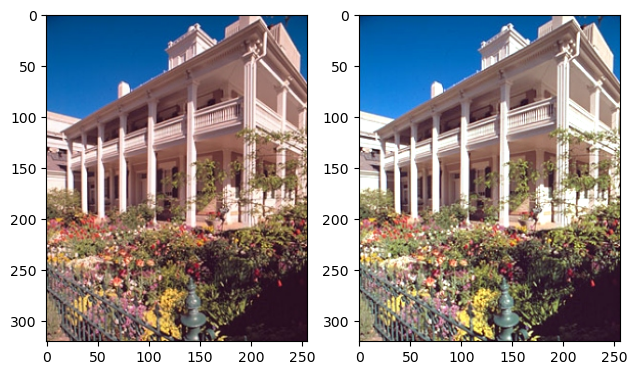

In [60]:
def grey_world(awb_img):
    """
    ================
    Your code here
    ================
    """
    
    R = awb_img[:, :, 0]
    G = awb_img[:, :, 1]
    B = awb_img[:, :, 2]

    Alpha_R = ((R / np.mean(R.flatten()) * 128) )
    Beta_G = ((G / np.mean(G.flatten()) * 128) )
    Gamma_B = ((B / np.mean(B.flatten()) * 128) )
    
#     Alpha_R *= 255 / np.max(Alpha_R)
#     Beta_G *= 255 / np.max(Beta_G)
#     Gamma_B *= 255 / np.max(Gamma_B)
    
    return np.dstack((Alpha_R.astype(np.uint16), Beta_G.astype(np.uint16), Gamma_B.astype(np.uint16)))

#     R = np.minimum(awb_img[:, :, 0] / 128, 255)
#     G = np.minimum(awb_img[:, :, 1] / 128, 255)
#     B = np.minimum(awb_img[:, :, 2] / 128, 255)
#     print(R)
#     return np.dstack((R, G, B))
#     awb_img = awb_img.astype(np.float32)
    
#     R = awb_img[:, :, 0]
#     G = awb_img[:, :, 1]
#     B = awb_img[:, :, 2]

#     Alpha_R = (R / np.mean(R.flatten()) * 128).astype(np.uint16).clip( max = 255)
#     Beta_G = (G / np.mean(G.flatten()) * 128).astype(np.uint16).clip( max = 255)
#     Gamma_B = (B / np.mean(B.flatten()) * 128).astype(np.uint16).clip( max = 255)

#     print(Alpha_R)
#     return np.dstack((Alpha_R, Beta_G, Gamma_B))

img_path = 'images/awb/awb.jpg'
I = cv2.imread(img_path)
I = I[:, :, ::-1]

fig = plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(I)
plt.subplot(1, 2, 2)
plt.imshow(grey_world(I))
fig.tight_layout()


2. Give an example case for Grey-World Algorithm on where it might fail. Remember to include your reasoning.

3. Find out one more colour constancy algorithms from the literature and explain it briefly.

*Write your answer here*